## Predicting skipped element of DNA sequence with RNN

In [1]:
!pip install biopython

In [2]:
import numpy as np
import pandas as pd
import math
from Bio import SeqIO
from sklearn.preprocessing import OneHotEncoder
import torch
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Defining device we use for training (if GPU is availible then CUDA)
if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda:0')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

In [3]:
# Initialize global constants
PATH_INPUT = '../input/dna-sequences/'
PATH_OUTPUT = './'
BATCH_SIZE = 1024
TRAIN_ONE_FOLD = True
RANDOM_SEED = 42
NUM_FOLDS = 8
NUM_EPOCHS = 1000

In [4]:
# Parsing initial sequences and creating Series with initial sequences
fasta_iterator = SeqIO.parse(open(PATH_INPUT+'mart_export.txt'),'fasta')

init_sequences = []
for fasta in fasta_iterator:
    sequence = str(fasta.seq)
    init_sequences.append(sequence)
    
init_seqs = pd.Series(init_sequences)

In [5]:
# Filtering initial sequences
init_seqs = init_seqs[init_seqs.transform(lambda x: ('A' in x)&('T' in x)&('C' in x)&('G' in x))]

# Removing "N" at the start of sequence
def remove_N(seq):
    i = 0
    for x in seq:
        if x == 'N':
            i+=1
        else: 
            break
        
    return seq[i:]

init_seqs = init_seqs.transform(lambda x: remove_N(x))

# Dropping if there are more then 4 distinct symbols in initial sequence and length < 61
init_seqs.drop(init_seqs.index[init_seqs.transform(lambda x: len(set(x)) != 4)], inplace=True)
init_seqs.drop(init_seqs.index[init_seqs.transform(lambda x: len(x) < 61)], inplace=True)
init_seqs.reset_index(inplace=True, drop=True)

# Converting strings to id lists
mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
init_seqs = init_seqs.transform(lambda x: [mapping[symbol] for symbol in x])

In [ ]:
init_seqs.transform(lambda x: len(x)).describe()

In [6]:
# Creating sequences with random lengths beetween 11 and 61 out of parsed long sequences
# Then adding padding to bring sequences to equal lenghts
seqs = []
for elem in tqdm(init_seqs):
    i = 0
    while i < len(elem)-61:
        seq_with_pad = [4]*61  # 4 is an id of '<pad>'
        seq_length = np.random.randint(11,61)
        seq = elem[i:i+seq_length]
        j = np.random.randint(np.max([seq_length-31, 5]), np.min([31, seq_length-5]))
        target = seq[j]  # Creating target
        seq_with_pad[30-j:30-j+seq_length] = seq
        seqs.append(seq_with_pad)
        i+=seq_length
seqs = np.array(seqs).reshape(-1, 61, 1)
print(len(seqs), 'sequences obtained')

In [7]:
# Creating class for early stopping
class EarlyStopping():
    
    def __init__(self, model, patience: int = 10):
        
        self.patience = patience
        self.model = model
        self.min_loss = None
        self.model_state = None
        self.step_num = 1
        self.last_good_step = 1
        
    def step(self, val_loss: float):
        
        if np.where(self.min_loss is None, val_loss+1, self.min_loss) > val_loss:
            self.min_loss = val_loss
            self.model_state = model.state_dict()
            self.last_good_step = self.step_num
        if self.last_good_step <= self.step_num - self.patience:
            return True
        else:
            self.step_num+=1
            return False        

In [8]:
# Creating model class
class RNN(nn.Module):

    def __init__(self, n_token: int = 5, d_model: int = 256, n_layers: int = 4, 
                 dropout: float = 0.05, seq_length: int = 30
                ):
        super().__init__()
        self.d_model = d_model
        self.seq_length = seq_length
        self.encoder = nn.Embedding(n_token, d_model)
        self.lstm_left = nn.LSTM(d_model, d_model, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.lstm_right = nn.LSTM(d_model, d_model, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.norm = nn.LayerNorm(d_model*2)
        self.linear = nn.Linear(d_model*2, n_token-1)
    
    def forward(self, x):
        x = self.encoder(x)
        # Model applies LSTM to elements of sequence that are left and right to target
        x_left, hc = self.lstm_left(x[:,:self.seq_length,:])
        # LSTM applied to elements that are right to target in reversed order
        x_right, hc = self.lstm_right(torch.flip(x[:,self.seq_length+1:,:], dims=[-2]))
        x_left = x_left[:, -1, :]
        x_right = x_right[:, -1, :]
        x = torch.cat([x_left, x_right], axis=-1)
        x = self.norm(x)
        x = self.linear(x)

        return x

In [16]:
# Creating training functions
def do_epoch(data, model, objective, optimizer=None, scheduler=None, batch_size=BATCH_SIZE, name=None, part=0.1):

    epoch_loss, epoch_accuracy = 0, 0

    # If optimizer is used then it's training 
    is_train = not optimizer is None
    model.train(is_train)

    # Number of training batches
    batch_count = int(len(data)*part)//batch_size + 1
    
    # Initializing sampler and loader
    # Sampler used to be able to randomly load a part of training data
    sampler = torch.utils.data.RandomSampler(data, replacement=True, num_samples=int(len(data)*part))
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, sampler=sampler)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batch_count) as progress_bar:
            for i, (data_batch) in enumerate(loader):
                
                # Creating batches for training
                X_batch = data_batch.squeeze(dim=-1).to(DEVICE)
                y_batch = data_batch[:, 30, :].squeeze(dim=-1).to(DEVICE)

                y_pred_batch = model(X_batch)
                
                # Calculating loss and adding to final epoch loss
                loss = objective(y_pred_batch, y_batch)
                epoch_loss += loss.item()
                
                # If training then implement optimizer
                if is_train:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                # Calculating accuracy and adding to final epoch accuracy
                accuracy = (y_pred_batch.argmax(dim=-1) == y_batch).sum() / batch_size
                epoch_accuracy += accuracy.item()
                
                # In proccess progress bar update
                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}. Accuracy = {:.5f}'.format(
                    name, loss.item(), accuracy.item())
                )
            
            # Final progress bar update
            progress_bar.update()
            progress_bar.set_description('{:>5s} Loss = {:.5f}. Accuracy = {:.5f}'.format(
                name, epoch_loss / batch_count, epoch_accuracy / batch_count)
            )
        
    return epoch_loss / batch_count, epoch_accuracy / batch_count


def fit(train_data, model, objective, val_data=None, optimizer=None, scheduler=None, 
        early_stop=None, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, part=0.1
       ):

    train_loss_history, val_loss_history = [], []
    train_accuracy_history, val_accuracy_history = [], []

    # Loop train and validation for a number of epochs
    for epoch in range(num_epochs):
        name_prefix = '[{} / {}] '.format(epoch + 1, num_epochs)
        train_loss, train_accuracy = do_epoch(train_data, model, objective, optimizer, scheduler, batch_size, name_prefix + 'Train:', part=part)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        
        if not val_data is None:
            val_loss, val_accuracy = do_epoch(val_data, model, objective, None, None, batch_size, name_prefix + '  Val:', part=1.0)
            val_loss_history.append(val_loss_history)
            val_accuracy_history.append(val_accuracy)
        
        # Scheduler step 
        if scheduler: scheduler.step(val_loss)
        
        # Early stop step
        if not early_stop is None:
            is_stop = early_stop.step(val_loss)
            if not early_stop.step_num % 5:  # Saving best model every 5 epochs
                torch.save(early_stop.model_state, PATH_OUTPUT + 'saved_model_state.ms')
            if is_stop: break
    
    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

In [17]:
# Training cell
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# Using 80% of sequences for train and validation datasets, 20% for test dataset
for fold, (train_idx, val_idx) in enumerate(kf.split(seqs[:int(len(seqs)*0.8)])):  

    print('--------KFold: %i--------'%(fold))

    seqs_train, seqs_val = seqs[train_idx], seqs[val_idx]
    
    model = RNN().to(DEVICE)

    early_stop = EarlyStopping(model, patience=9)
    optimizer = optim.Adam(model.parameters())
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=6, verbose=2)
    objective = nn.CrossEntropyLoss()
    
    train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history = \
    fit(seqs_train, model, objective, seqs_val, optimizer, scheduler, early_stop, NUM_EPOCHS, batch_size=BATCH_SIZE, part=0.2)
    
    # Train and val score
    train_val_loss, train_val_accuracy = \
    do_epoch(seqs[:int(len(seqs)*0.8)], model, objective, optimizer=None, scheduler=None, batch_size=BATCH_SIZE, name='Train and Val:', part=1.0)
    
    # Test score
    test_loss, test_accuracy = \
    do_epoch(seqs[int(len(seqs)*0.8):], model, objective, optimizer=None, scheduler=None, batch_size=BATCH_SIZE, name='Test:', part=1.0)

    # Saving final model version
    torch.save(early_stop.model_state, PATH_OUTPUT + 'fold'+str(i)+'_model_state.ms')

    if TRAIN_ONE_FOLD: break

In [ ]:
losses, accs, val_losses, val_accs = \
np.asarray(train_loss_history).astype('float16'), \
np.asarray(train_accuracy_history).astype('float16'), \
np.asarray(val_loss_history).astype('float16'), \
np.asarray(val_accuracy_history).astype('float16')

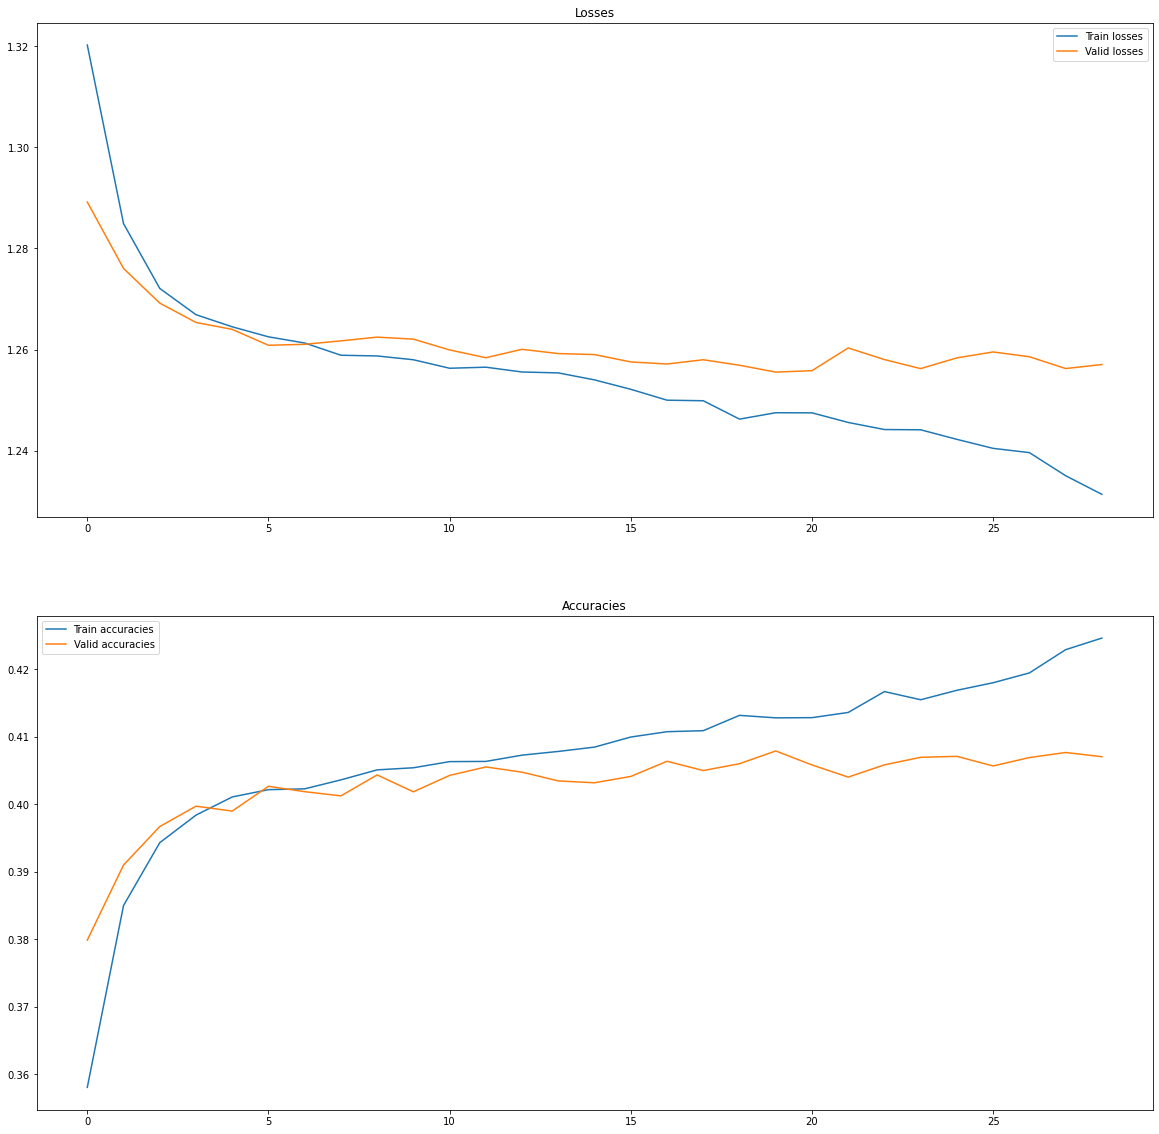

In [9]:
# Plotting training history
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(20, 20)
ax1.set_title('Losses')
ax1.plot(losses, label='Train losses')
ax1.plot(val_losses, label='Valid losses')
ax1.legend()
ax2.set_title('Accuracies')
ax2.plot(accs, label = 'Train accuracies')
ax2.plot(val_accs, label = 'Valid accuracies')
ax2.legend()

TRAINING LOG

--------KFold: 0--------

[1 / 1000] Train: Loss = 1.32017. Accuracy = 0.35808: : 471it [01:17,  6.06it/s]                       
[1 / 1000]   Val: Loss = 1.28915. Accuracy = 0.37988: : 337it [00:16, 20.61it/s]                       
[2 / 1000] Train: Loss = 1.28489. Accuracy = 0.38500: : 471it [01:17,  6.06it/s]                       
[2 / 1000]   Val: Loss = 1.27603. Accuracy = 0.39099: : 337it [00:15, 21.88it/s]                       
[3 / 1000] Train: Loss = 1.27208. Accuracy = 0.39430: : 471it [01:17,  6.06it/s]                       
[3 / 1000]   Val: Loss = 1.26918. Accuracy = 0.39669: : 337it [00:16, 20.93it/s]                       
[4 / 1000] Train: Loss = 1.26689. Accuracy = 0.39838: : 471it [01:17,  6.05it/s]                       
[4 / 1000]   Val: Loss = 1.26536. Accuracy = 0.39970: : 337it [00:15, 22.02it/s]                       
[5 / 1000] Train: Loss = 1.26450. Accuracy = 0.40107: : 471it [01:17,  6.05it/s]                       
[5 / 1000]   Val: Loss = 1.26399. Accuracy = 0.39898: : 337it [00:16, 20.92it/s]                       
[6 / 1000] Train: Loss = 1.26252. Accuracy = 0.40215: : 471it [01:17,  6.06it/s]                       
[6 / 1000]   Val: Loss = 1.26085. Accuracy = 0.40265: : 337it [00:15, 22.00it/s]                       
[7 / 1000] Train: Loss = 1.26130. Accuracy = 0.40227: : 471it [01:17,  6.07it/s]                       
[7 / 1000]   Val: Loss = 1.26104. Accuracy = 0.40185: : 337it [00:16, 20.75it/s]                       
[8 / 1000] Train: Loss = 1.25888. Accuracy = 0.40360: : 471it [01:17,  6.06it/s]                       
[8 / 1000]   Val: Loss = 1.26172. Accuracy = 0.40123: : 337it [00:15, 21.86it/s]                       
[9 / 1000] Train: Loss = 1.25874. Accuracy = 0.40508: : 471it [01:17,  6.06it/s]                       
[9 / 1000]   Val: Loss = 1.26246. Accuracy = 0.40433: : 337it [00:16, 20.73it/s]                       
[10 / 1000] Train: Loss = 1.25799. Accuracy = 0.40539: : 471it [01:17,  6.06it/s]                       
[10 / 1000]   Val: Loss = 1.26206. Accuracy = 0.40183: : 337it [00:15, 22.00it/s]                       
[11 / 1000] Train: Loss = 1.25631. Accuracy = 0.40630: : 471it [01:17,  6.06it/s]                       
[11 / 1000]   Val: Loss = 1.25993. Accuracy = 0.40426: : 337it [00:15, 21.91it/s]                       
[12 / 1000] Train: Loss = 1.25652. Accuracy = 0.40633: : 471it [01:18,  6.00it/s]                       
[12 / 1000]   Val: Loss = 1.25839. Accuracy = 0.40551: : 337it [00:15, 22.00it/s]                       
[13 / 1000] Train: Loss = 1.25557. Accuracy = 0.40726: : 471it [01:17,  6.06it/s]                       
[13 / 1000]   Val: Loss = 1.26005. Accuracy = 0.40474: : 337it [00:15, 21.67it/s]                       
[14 / 1000] Train: Loss = 1.25539. Accuracy = 0.40781: : 471it [01:18,  6.00it/s]                       
[14 / 1000]   Val: Loss = 1.25921. Accuracy = 0.40344: : 337it [00:15, 21.84it/s]                       
[15 / 1000] Train: Loss = 1.25401. Accuracy = 0.40845: : 471it [01:17,  6.06it/s]                       
[15 / 1000]   Val: Loss = 1.25901. Accuracy = 0.40317: : 337it [00:15, 21.79it/s]                       
[16 / 1000] Train: Loss = 1.25215. Accuracy = 0.40994: : 471it [01:18,  6.00it/s]                       
[16 / 1000]   Val: Loss = 1.25756. Accuracy = 0.40411: : 337it [00:15, 21.85it/s]                       
[17 / 1000] Train: Loss = 1.25000. Accuracy = 0.41073: : 471it [01:17,  6.06it/s]                       
[17 / 1000]   Val: Loss = 1.25715. Accuracy = 0.40635: : 337it [00:15, 21.99it/s]                       
[18 / 1000] Train: Loss = 1.24989. Accuracy = 0.41088: : 471it [01:18,  5.99it/s]                       
[18 / 1000]   Val: Loss = 1.25799. Accuracy = 0.40498: : 337it [00:15, 21.99it/s]                       
[19 / 1000] Train: Loss = 1.24626. Accuracy = 0.41315: : 471it [01:17,  6.06it/s]                       
[19 / 1000]   Val: Loss = 1.25690. Accuracy = 0.40599: : 337it [00:15, 21.95it/s]                       
[20 / 1000] Train: Loss = 1.24752. Accuracy = 0.41278: : 471it [01:18,  5.99it/s]                       
[20 / 1000]   Val: Loss = 1.25555. Accuracy = 0.40788: : 337it [00:15, 21.86it/s]                       
[21 / 1000] Train: Loss = 1.24750. Accuracy = 0.41281: : 471it [01:17,  6.06it/s]                       
[21 / 1000]   Val: Loss = 1.25583. Accuracy = 0.40581: : 337it [00:15, 21.78it/s]                       
[22 / 1000] Train: Loss = 1.24560. Accuracy = 0.41358: : 471it [01:18,  6.00it/s]                       
[22 / 1000]   Val: Loss = 1.26032. Accuracy = 0.40401: : 337it [00:15, 21.87it/s]                       
[23 / 1000] Train: Loss = 1.24420. Accuracy = 0.41667: : 471it [01:17,  6.07it/s]                       
[23 / 1000]   Val: Loss = 1.25802. Accuracy = 0.40582: : 337it [00:15, 21.94it/s]                       
[24 / 1000] Train: Loss = 1.24415. Accuracy = 0.41546: : 471it [01:18,  6.00it/s]                       
[24 / 1000]   Val: Loss = 1.25624. Accuracy = 0.40694: : 337it [00:15, 21.95it/s]                       
[25 / 1000] Train: Loss = 1.24226. Accuracy = 0.41686: : 471it [01:17,  6.06it/s]                       
[25 / 1000]   Val: Loss = 1.25836. Accuracy = 0.40708: : 337it [00:15, 21.95it/s]                       
[26 / 1000] Train: Loss = 1.24048. Accuracy = 0.41798: : 471it [01:18,  6.00it/s]                       
[26 / 1000]   Val: Loss = 1.25953. Accuracy = 0.40566: : 337it [00:15, 21.88it/s]                       
[27 / 1000] Train: Loss = 1.23964. Accuracy = 0.41943: : 471it [01:17,  6.07it/s]                       
[27 / 1000]   Val: Loss = 1.25859. Accuracy = 0.40690: : 337it [00:15, 21.78it/s]                       
Epoch    27: reducing learning rate of group 0 to 3.0000e-04.

[28 / 1000] Train: Loss = 1.23508. Accuracy = 0.42287: : 471it [01:17,  6.06it/s]                       
[28 / 1000]   Val: Loss = 1.25625. Accuracy = 0.40765: : 337it [00:16, 20.86it/s]                       
[29 / 1000] Train: Loss = 1.23140. Accuracy = 0.42459: : 471it [01:17,  6.06it/s]                       
[29 / 1000]   Val: Loss = 1.25704. Accuracy = 0.40703: : 337it [00:15, 21.90it/s]                       

Train and Val: Loss = 1.23244. Accuracy = 0.42455: : 2683it [02:04, 21.48it/s]      

Test: Loss = 1.25547. Accuracy = 0.40417: : 136it [00:06, 21.89it/s]      